In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import minimize, LinearConstraint, Bounds

In [2]:
file_path = "/content/drive/MyDrive/Cleaned_Data/export_data.csv"

df = pd.read_csv(file_path, index_col = 0)
df.head(2)

,AAPL,ABCB,ACGL,ADBE,ADI,ADP,ADSK,AEP,AMAT,AMD,...,VLY,VRTX,WABC,WAFD,WBA,WERN,WSFS,WTFC,XEL,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,0.088754,0.011765,-0.089109,-0.025093,-0.030242,-0.034803,-0.011111,-0.021400,-0.001480,0.071274,...,-0.037946,0.073214,-0.080537,-0.069620,-0.023504,-0.031111,-0.029703,-0.032787,-0.025641,-0.062302
2000-01-04,-0.084310,-0.011628,-0.005435,-0.083889,-0.050590,0.000000,-0.048689,0.011928,-0.049407,-0.056452,...,-0.051044,-0.079867,-0.017031,-0.023809,-0.037199,-0.002294,-0.030612,0.000000,0.023026,-0.048424


# 0 Defining Necessary Functions

In [3]:
def portfolio_gross_return (r, w):
  "Expected return of the portfolio is the weighted average of returns of the assets composing it. Not adjusted for costs. Return as % of capital invested"
  #r represents the returns of each asset
  #w represents the weights that go to each asset
  return np.dot(r,w)

def portfolio_volatility (w, covar):
  "Portfolio volatility is the following matrix multiplication: w^T . covariance_matrix . w"
  #w = weights ; covar = covariance matrix
  return np.sqrt(np.dot(w.T, np.dot(covar, w)))

def adjusted_port_return (portfolio_gross_return, initial_weights,  desired_weights, transaction_rate):
  "Desired weights are those obtained from the optimization. Transaction rate represents the % of transactions (change in weights) that represent costs"
  #We think of transaction costs calculation as a % of returns derived from the rate of weight changes that represent costs
  # % adjusted return = % gross return - % transaction cost
  #                 = % gross return - (sum(transaction_rate * weight changes))
  # Recall that because we used the .pct_change() pandas function to calculate returns, all returns are percentage returns

  vector_transaction_costs = transaction_rate * np.abs(initial_weights - desired_weights)
  total_transaction_costs = np.sum(vector_transaction_costs)
  adjusted_return = portfolio_gross_return - total_transaction_costs
  return adjusted_return


# 1 Risk Parity Approach

In [4]:
len(df.std())

110

In [5]:
#Inverse Volatility Formula for Calculating weights under the Risk Parity Framework
def calculate_weights(data):
  "We want the contribution to total risk (volatility) of each asset to be equal, hence the weighting scheme"
  vol = data.std().dropna()  #Since we want an annual rebalancing we want an annual moving volatility (for weightings)
  inv_vol = 1 / vol
  weights = inv_vol / np.sum(inv_vol)
  return weights

In [6]:
# Function to backtest the Minimum-Variance optimization strategy with annual rebalancing
def backtest_RiskP_strategy(returns, transaction_cost_rate):
    num_assets = len(returns.columns)       #Returns meaning our daily return data: our dataframe
    num_days = len(returns)
    rebalancing_period = 252  # Number of trading days in a year
    investing_capital = 10000   #The capital to be used with this strategy
    initial_transaction_cost = np.sum(np.dot(np.ones(num_assets), 1/num_assets)) * transaction_cost_rate #Initial transaction cost (in %) resulting from buying the equally weighted portfolio (from 0 weighting to 1/n)
    initial_portfolio_value = investing_capital - initial_transaction_cost * investing_capital  #The amount we would invest, adjusted for initial cost. And we will see how it evolves over time
    portfolio_value = initial_portfolio_value
    portfolio_values = [initial_portfolio_value]
    adjusted_returns = []
    portfolio_volatilities = []
    previous_weights = np.ones(num_assets) / num_assets  # Initial equally weighted portfolio

    for day in range(num_days):
        if day % rebalancing_period == 0 and day > 0:

            #Define in_sample data to be used for calculations
            in_sample_data = returns.iloc[:day]

            # Calculate weights using Risk Parity inverse volatility formula (using a rolling stdev for volatility of assets)
            weights = calculate_weights(in_sample_data)

            # Calculate portfolio returns (daily)
            portfolio_return = portfolio_gross_return(returns.iloc[day], weights)

            # Adjust returns for transaction costs
            adjusted_return = adjusted_port_return(portfolio_return, previous_weights, weights, transaction_cost_rate )

            # Store adjusted returns
            adjusted_returns.append(adjusted_return)

            # Update portfolio value
            portfolio_value = portfolio_values[-1] * (1 + adjusted_return)

            # Store portfolio value
            portfolio_values.append(portfolio_value)

            # Calculate portfolio volatility and store value (daily)
            covariance_matrix = in_sample_data.cov()
            portfolio_volatility_value = portfolio_volatility(weights, covariance_matrix)
            portfolio_volatilities.append(portfolio_volatility_value)

            #In the next period, optimized weights in this period will be the previous weights
            previous_weights = weights
        else:
            # Calculate portfolio returns (daily) (even if we do not rebalance we calculate returns because we still hold the assets)
            portfolio_return = portfolio_gross_return(returns.iloc[day], previous_weights)

            #If there is no rebalancing, there are no transaction costs for this period
            adjusted_return = portfolio_return

            # Store adjusted returns
            adjusted_returns.append(adjusted_return)

            # Update portfolio value
            portfolio_value = portfolio_values[-1] * (1 + adjusted_return)

            # Store portfolio value
            portfolio_values.append(portfolio_value)

            #Calculate the covariance up to this point, to track volatility (even if we do not rebalance we calculate volatility)
            covar_data = returns.iloc[:day]
            covar_matrix = covar_data.cov()

            # Recalculate portfolio volatility (daily) and store value
            portfolio_volatility_value = portfolio_volatility(previous_weights, covar_matrix)
            portfolio_volatilities.append(portfolio_volatility_value)

    return portfolio_values, adjusted_returns, portfolio_volatilities

In [7]:
transaction_rate = 0.01     #As a % of substracted returns resulting from weight rebalancing

RiskP_port_values, RiskP_port_returns, RiskP_port_vols = backtest_RiskP_strategy(df, transaction_rate)

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: divide by zero encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.10/dist-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


In [8]:
RiskP_returns_and_vol = pd.DataFrame({"Risk P Portfolio Returns": RiskP_port_returns, "Risk P Volatility": RiskP_port_vols })
RiskP_returns_and_vol = RiskP_returns_and_vol.dropna()
len(RiskP_returns_and_vol)

5092

In [9]:
RiskP_returns_and_vol["Rolling Sharpe Ratio"] = np.sqrt(252) * (RiskP_returns_and_vol["Risk P Portfolio Returns"].rolling(252).mean() / RiskP_returns_and_vol["Risk P Volatility"].rolling(252).mean())
RiskP_returns_and_vol

,Risk P Portfolio Returns,Risk P Volatility,Rolling Sharpe Ratio
2,0.007721,0.011441,NaN
3,-0.006257,0.019683,NaN
4,0.020144,0.016421,NaN
5,0.016604,0.020004,NaN
6,-0.016055,0.019952,NaN
...,...,...,...
5089,0.070379,0.013568,-0.067750
5090,-0.035420,0.013602,-0.270092
5091,0.030142,0.013610,-0.139840
5092,-0.013401,0.013615,-0.288601


# 2 Hierarchical Risk Parity Approach (HRP)

In [10]:
!pip install Riskfolio-Lib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.0/301.0 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 62.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 82.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 64.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.0/235.0 kB 31.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: cvxpy
    Found existing installation: cvxpy 1.3.3
    Uninstalling cvxpy-1.3.3:
      Successfully uninstalled cvxpy-1.3.3


In [11]:
import warnings
import riskfolio as rp

warnings.filterwarnings("ignore")     #To avoid unnecessary outputs
pd.options.display.float_format = '{:.4%}'.format

HRP algorithm creates a hierarchical structure of assets from the correlation matrix: It starts with each observation as a separate cluster and merges them based on similarity. Mathematically, the similarity between two clusters can be represented using the Euclidean distance d(X,Y) between two data points X and Y in an n-dimensional space.

From this hierarchies the algorithm forms a dendogram (see plot below) and performs the matrix seriation: sorts the assets in the dendrogram minimizing the distance between leafs (or dendrites). It connects all assets in a way where the total weight or distance between them is minimized. This is also done automatically by the clustermap function from Seaborn. In the plot below, the correlation matrix has been "reorganized" to match the correlational hierarchies (as opposed to heatmap function which does not do this).

Finally, the algorithm splits the weights along the dendrogram using risk parity (weights based on the inverse of asset’s risk (but variance)) from the top of the tree(dendogram) to the leafs (dendrites). That is, we optimize for the contribution of risk of each cluster, and then from each asset within each cluster.

<Axes: >

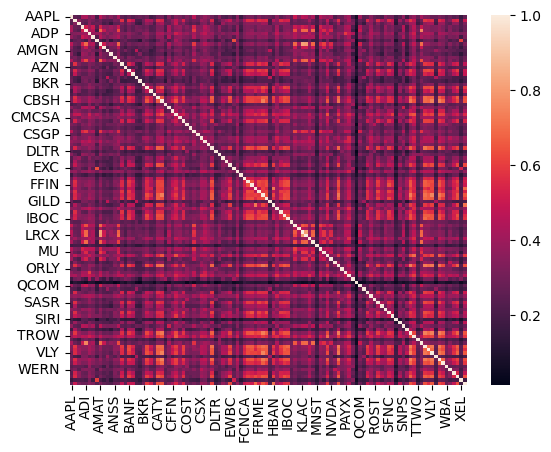

In [12]:
sns.heatmap(df.corr()) #To check the difference with cluster map (corr matrix with no seriation)

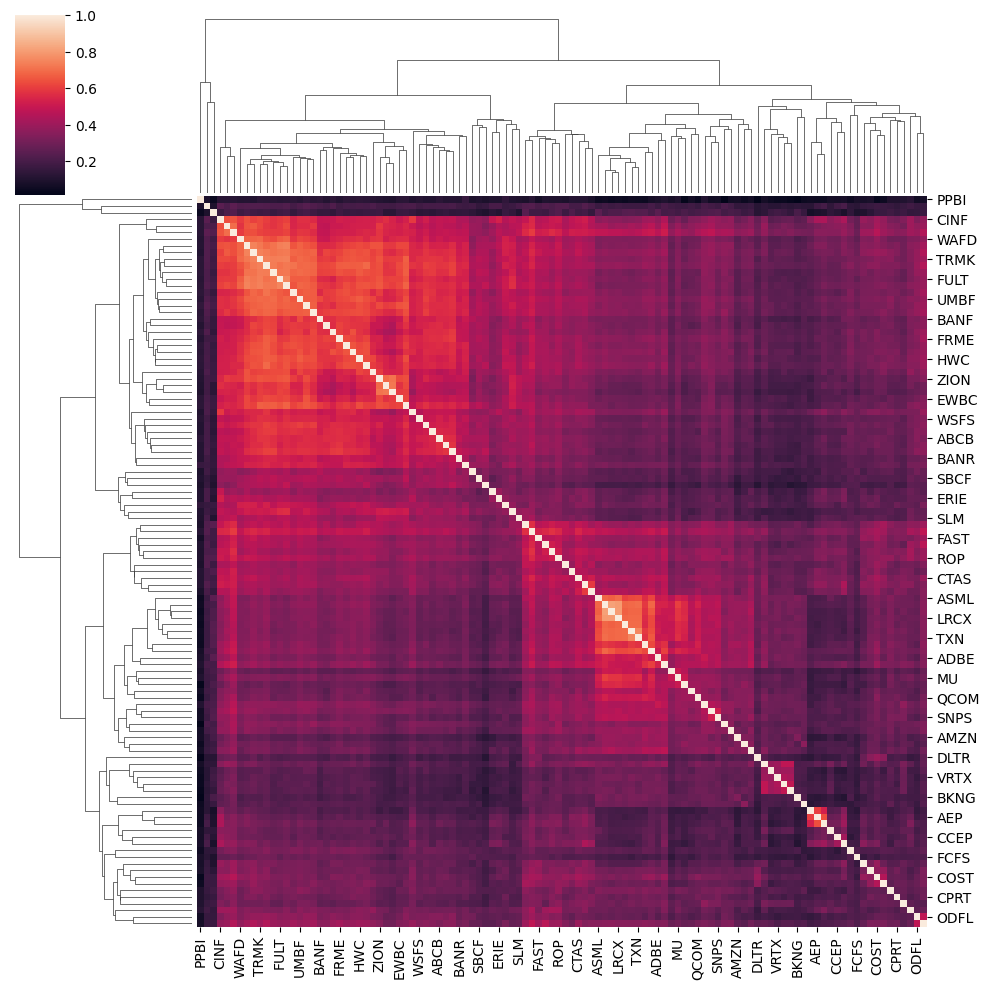

In [13]:
#Seriated Correlation Matrix and Clusters (dendogram)
sns.clustermap(df.corr())

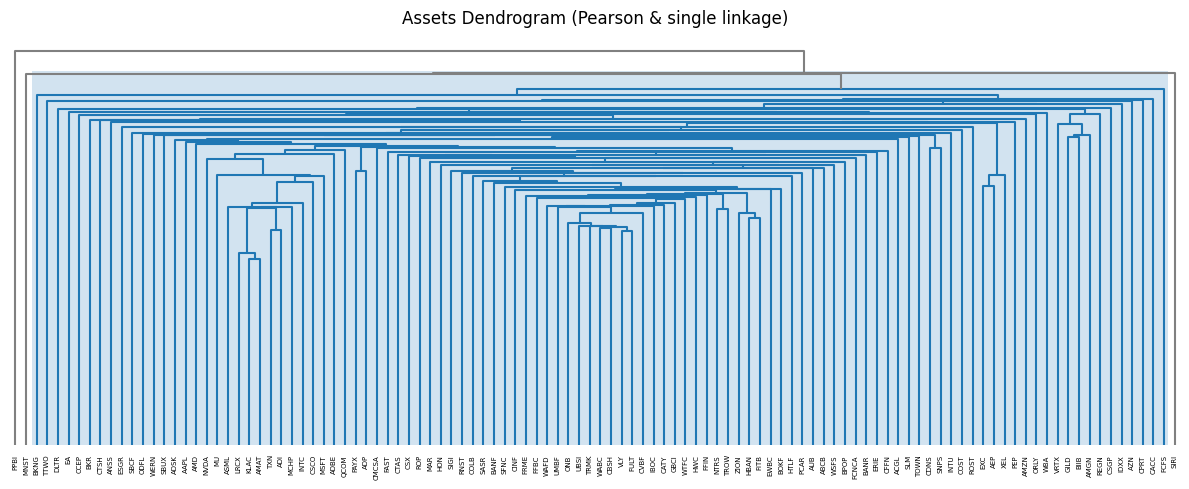

In [14]:
#Plotting only the dendogram (not very visually appealing)
ax = rp.plot_dendrogram(returns=df,
                        codependence='pearson',
                        linkage='single',
                        k=None,
                        leaf_order=True,
                        ax=None)

In [15]:
#Define parameters before backtesting
model='HRP'
codependence = 'pearson' # Correlation matrix used to group assets in clusters
rm = 'MV' # Risk measure used, this time will be variance
rf = 0 # Risk free rate assumption
max_k = 10 # Max number of clusters used in two difference gap statistic, only used for compatibility issues
linkage = 'single' # Linkage method used to build clusters
leaf_order = True # Consider optimal order of leafs in dendrogram

In [16]:
# Function to backtest the Minimum-Variance optimization strategy with annual rebalancing
def backtest_HRP_strategy(returns, transaction_cost_rate):
    num_assets = len(returns.columns)       #Returns meaning our daily return data: our dataframe
    num_days = len(returns)
    rebalancing_period = 252  # Number of trading days in a year
    investing_capital = 10000   #The capital to be used with this strategy
    initial_transaction_cost = np.sum(np.dot(np.ones(num_assets), 1/num_assets)) * transaction_cost_rate #Initial transaction cost (in %) resulting from buying the equally weighted portfolio (from 0 weighting to 1/n)
    initial_portfolio_value = investing_capital - initial_transaction_cost * investing_capital  #The amount we would invest, adjusted for initial cost. And we will see how it evolves over time
    portfolio_value = initial_portfolio_value
    portfolio_values = [initial_portfolio_value]
    adjusted_returns = []
    portfolio_volatilities = []
    previous_weights = np.ones(num_assets) / num_assets  # Initial equally weighted portfolio

    for day in range(num_days):
        if day % rebalancing_period == 0 and day > 0:

            #Define in_sample data to be used for calculations
            in_sample_data = returns.iloc[:day]

            # Building the portfolio object
            port = rp.HCPortfolio(returns=in_sample_data)

            # Calculate weights using HRP Model(output is a dataframe of weights by stock)
            weights_df = port.optimization(model=model,
                      codependence=codependence,
                      rm=rm,
                      rf=rf,
                      max_k= max_k,
                      linkage=linkage,
                      leaf_order=leaf_order)

            #Convert weights_df to an array for calculations
            weights = weights_df.values.reshape(110,)  #I reshape to prevent errors in the calculations below

            # Calculate portfolio returns (daily)
            portfolio_return = portfolio_gross_return(returns.iloc[day], weights)

            # Adjust returns for transaction costs
            adjusted_return = adjusted_port_return(portfolio_return, previous_weights, weights, transaction_cost_rate )

            # Store adjusted returns
            adjusted_returns.append(adjusted_return)

            # Update portfolio value
            portfolio_value = portfolio_values[-1] *(1 + adjusted_return)

            # Store portfolio value
            portfolio_values.append(portfolio_value)

            # Calculate portfolio volatility and store value (daily)
            covariance_matrix = in_sample_data.cov()
            portfolio_volatility_value = portfolio_volatility(weights, covariance_matrix)
            portfolio_volatilities.append(portfolio_volatility_value)

            #In the next period, optimized weights in this period will be the previous weights
            previous_weights = weights
        else:
            # Calculate portfolio returns (daily) (even if we do not rebalance we calculate returns because we still hold the assets)
            portfolio_return = portfolio_gross_return(returns.iloc[day], previous_weights)

            #If there is no rebalancing, there are no transaction costs for this period
            adjusted_return = portfolio_return

            # Store adjusted returns
            adjusted_returns.append(adjusted_return)

            # Update portfolio value
            portfolio_value = portfolio_values[-1] *(1 + adjusted_return)

            # Store portfolio value
            portfolio_values.append(portfolio_value)

            #Calculate the covariance up to this point, to track volatility (even if we do not rebalance we calculate volatility)
            covar_data = returns.iloc[:day]
            covar_matrix = covar_data.cov()

            # Recalculate portfolio volatility (daily) and store value
            portfolio_volatility_value = portfolio_volatility(previous_weights, covar_matrix)
            portfolio_volatilities.append(portfolio_volatility_value)

    return portfolio_values, adjusted_returns, portfolio_volatilities

In [17]:
transaction_rate = 0.01

HRP_port_values, HRP_port_returns, HRP_port_vols = backtest_HRP_strategy(df, transaction_rate)

In [18]:
HRP_returns_and_vol = pd.DataFrame({"HRP Portfolio Returns": HRP_port_returns, "HRP Volatility": HRP_port_vols })
HRP_returns_and_vol = HRP_returns_and_vol.dropna()
print(len(HRP_returns_and_vol))
HRP_returns_and_vol   #Pandas is showing our returns as %, but when calling the numbers or making calculations the actual returns are used (I tested it)

5092


,HRP Portfolio Returns,HRP Volatility
2,0.7721%,1.1441%
3,-0.6257%,1.9683%
4,2.0144%,1.6421%
5,1.6604%,2.0004%
6,-1.6055%,1.9952%
...,...,...
5089,7.1157%,1.2166%
5090,-3.1571%,1.2205%
5091,3.3162%,1.2212%
5092,-1.6909%,1.2219%


In [19]:
HRP_returns_and_vol["Rolling Sharpe Ratio"] = np.sqrt(252)* (HRP_returns_and_vol["HRP Portfolio Returns"].rolling(252).mean() / HRP_returns_and_vol["HRP Volatility"].rolling(252).mean())
HRP_returns_and_vol

,HRP Portfolio Returns,HRP Volatility,Rolling Sharpe Ratio
2,0.7721%,1.1441%,NaN
3,-0.6257%,1.9683%,NaN
4,2.0144%,1.6421%,NaN
5,1.6604%,2.0004%,NaN
6,-1.6055%,1.9952%,NaN
...,...,...,...
5089,7.1157%,1.2166%,-1.9643%
5090,-3.1571%,1.2205%,-21.8527%
5091,3.3162%,1.2212%,-5.3976%
5092,-1.6909%,1.2219%,-21.9878%


# 3 Comparison Plots

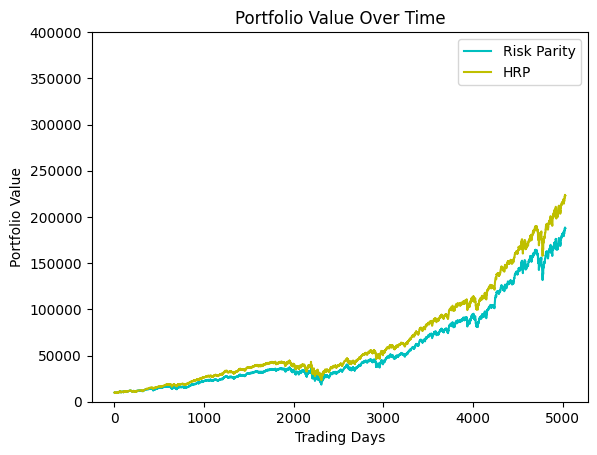

In [20]:
#In this plot we exclude COVID time because the downturn is misleading for visualization, and it is also the start of a new business cycle beyond the scope of the backtest.
plt.plot(RiskP_port_values[0:5030] , label = "Risk Parity", color = "c")
plt.plot(HRP_port_values[0:5030], label = "HRP", color = "y")
plt.title("Portfolio Value Over Time")
plt.xlabel("Trading Days")
plt.ylabel("Portfolio Value")
plt.ylim(0, 400000)
plt.legend()
plt.show()

In [21]:
print(RiskP_port_values[5030])
print(HRP_port_values[5030])

187353.55993587646
222477.10191288008


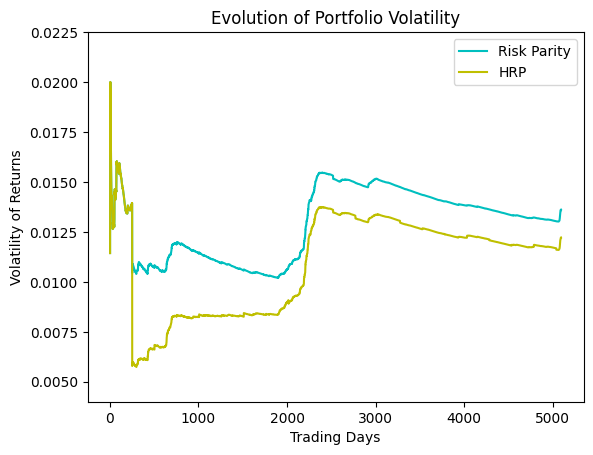

In [22]:
plt.plot(RiskP_port_vols, label = "Risk Parity", color = "c")
plt.plot(HRP_port_vols, label = "HRP", color = "y")
plt.title("Evolution of Portfolio Volatility")
plt.xlabel("Trading Days")
plt.ylabel("Volatility of Returns")
plt.legend()
plt.ylim(0.004, 0.0225)
plt.show()

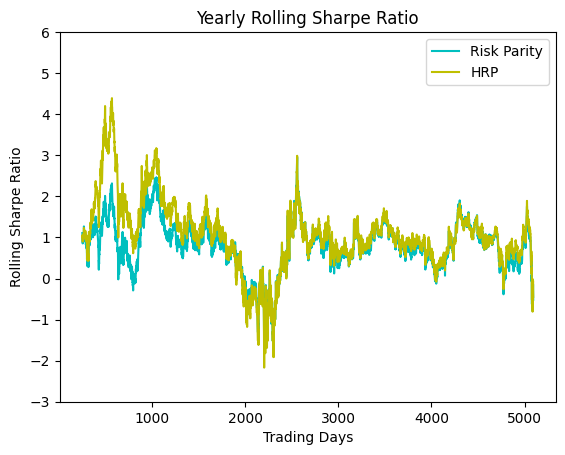

In [23]:
plt.plot(RiskP_returns_and_vol["Rolling Sharpe Ratio"].dropna(), label = "Risk Parity", color = "c")
plt.plot(HRP_returns_and_vol["Rolling Sharpe Ratio"].dropna(), label = "HRP", color = "y")
plt.title("Yearly Rolling Sharpe Ratio")
plt.xlabel("Trading Days")
plt.ylabel("Rolling Sharpe Ratio")
plt.ylim(-3, 6)
plt.legend()
plt.show()